In [125]:
# Contributors
# Alper Mumcular - am14533
# Anukriti Singh - as18692

# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

In [124]:
def convert_to_grayscale(image):
    # Convert RGB image to grayscale using given formula
    rgb = np.array(image)
    grayscale = np.round(0.299 * rgb[:,:,0] + 0.587 * rgb[:,:,1] + 0.114 * rgb[:,:,2]).astype(np.uint8)
    return grayscale

In [112]:
def compute_histogram(image):
    # Compute unnormalized histogram
    hist, _ = np.histogram(image, bins=256, range=(0,255))

    total = 0
    for value in hist:
        total += value

    # Normalize histogram
    hist = hist / total
    return hist

In [113]:
def calculate_mean(lower_bound, t, hist, w):
    total = 0
    # Multiply index by corresponding histogram value and add to total
    for i in range(lower_bound, t):
        total += i * hist[i]
    return total / w

In [114]:
def calculate_variance(lower_bound, t, mean, hist, w):
    # Initialize sum to 0
    variance_sum = 0

    # Iterate over all values within the range
    for i in range(lower_bound, t):
        # Calculate the difference squared and multiply by the corresponding histogram value (amount)
        diff_squared = (i - mean) ** 2
        variance_sum += diff_squared * hist[i]

    # Calculate variance by dividing by w
    variance = variance_sum / w

    return variance


In [115]:
def calculate_weight(hist, lower_bound, t):
    # Initialize the weight to 0
    weight = 0

    # Iterate over all values within the range and add it to the weight
    for i in range(lower_bound, t):
        weight += hist[i]

    return weight


In [116]:
def otsu(hist, num_thresh, lower_bound=0, upper_bound=255):
    # Represents minimum possible variance
    best_var = np.inf
    # Used to store regions' variances
    group_variances = []

    if num_thresh == 1: # 2 Region - 1 Threshold
        best_thresh = lower_bound

        # Try each value between lower bound and upper bound
        for t in range(lower_bound+1, upper_bound):
            # Calculate weights
            w0 = calculate_weight(hist, lower_bound, t+1)
            w1 = 1-w0

            # Zero weight will not help minimizing and avoid division by zero
            if w0 == 0 or w1 == 0:
                continue

            # Calculate means for foreground (1) and background (0)
            m0 = calculate_mean(lower_bound, t+1, hist, w0)
            m1 = calculate_mean(t+1, upper_bound+1, hist, w1)

            # Calculate variances for foreground (1) and background (0)
            v0 = calculate_variance(lower_bound, t+1, m0, hist, w0)
            v1 = calculate_variance(t+1, upper_bound+1, m1, hist, w1)

            # Compute total variance according to Otsu's method
            total_var = w0*v0 + w1*v1

            # If it is smaller, make this best result so far and store threshold value and its variances
            if total_var < best_var:
                best_var = total_var
                best_thresh = t
                group_variances = [v0, v1]

        return [best_thresh], best_var, group_variances

    elif num_thresh == 2: # 3 Region - 2 Threshold
        best_thresh1 = best_thresh2 = lower_bound

        # Try each possible value for first threshold
        for t1 in range(lower_bound + 1, upper_bound - 1):
            # This part is here to avoid calculating same result multiple times

            # Calculate first regions weight
            w0 = calculate_weight(hist, lower_bound, t1 + 1)
            if w0 == 0:
                continue

            # Calculate its mean and variance
            m0 = calculate_mean(lower_bound, t1 + 1, hist, w0)
            v0 = calculate_variance(lower_bound, t1 + 1, m0, hist, w0)

            # Try each possible value for second threshold
            for t2 in range(t1 + 1, upper_bound):
                # Calculate other two regions weight
                w1 = calculate_weight(hist, t1 + 1, t2 + 1)
                w2 = 1 - (w0+w1)

                if w1 == 0 or w2 == 0:
                    continue

                # Calculate other two regions mean and variance
                m1 = calculate_mean(t1 + 1, t2 + 1, hist, w1)
                m2 = calculate_mean(t2 + 1, upper_bound + 1, hist, w2)

                v1 = calculate_variance(t1 + 1, t2 + 1, m1, hist, w1)
                v2 = calculate_variance(t2 + 1, upper_bound + 1, m2, hist, w2)

                # Compute total variance according to Otsu's method
                total_var = w0 * v0 + w1 * v1 + w2 * v2

                # If it is smaller, make this best result so far and store threshold value and its variances
                if total_var < best_var:
                    best_var = total_var
                    best_thresh1, best_thresh2 = t1, t2
                    group_variances = [v0, v1, v2]

        return [best_thresh1, best_thresh2], best_var, group_variances

    else: # 4 Region - 3 Threshold
        best_thresh1 = best_thresh2 = best_thresh3 = lower_bound

        # Try each possible value for first threshold
        for t1 in range(lower_bound + 1, upper_bound - 2):
            # This part is here to avoid calculating same result multiple times

            # Calculate first region weight
            w0 = calculate_weight(hist, lower_bound, t1 + 1)
            if w0 == 0:
                continue

            # Calculate its mean and variance
            m0 = calculate_mean(lower_bound, t1 + 1, hist, w0)
            v0 = calculate_variance(lower_bound, t1 + 1, m0, hist, w0)

            # Try each possible value for second threshold
            for t2 in range(t1 + 1, upper_bound - 1):
                # This part is here to avoid calculating same result multiple times

                # Calculate second region weight
                w1 = calculate_weight(hist, t1 + 1, t2 + 1)
                if w1 == 0:
                    continue

                # Calculate its mean and variance
                m1 = calculate_mean(t1 + 1, t2 + 1, hist, w1)
                v1 = calculate_variance(t1 + 1, t2 + 1, m1, hist, w1)

                # Try each possible value for third threshold
                for t3 in range(t2 + 1, upper_bound):
                    # Compute remaining weights
                    w2 = calculate_weight(hist, t2 + 1, t3 + 1)
                    w3 = 1 - (w0 + w1 + w2)

                    if w2 == 0 or w3 == 0:
                        continue

                    # Compute remaining regions mean
                    m2 = calculate_mean(t2 + 1, t3 + 1, hist, w2)
                    m3 = calculate_mean(t3 + 1, upper_bound + 1, hist, w3)

                    # Compute remaining regions variance
                    v2 = calculate_variance(t2 + 1, t3 + 1, m2, hist, w2)
                    v3 = calculate_variance(t3 + 1, upper_bound + 1, m3, hist, w3)

                    # Compute total variance according to Otsu's method
                    total_var = w0 * v0 + w1 * v1 + w2 * v2 + w3 * v3

                    # If it is smaller, make this best result so far and store threshold value and its variances
                    if total_var < best_var:
                        best_var = total_var
                        best_thresh1, best_thresh2, best_thresh3 = t1, t2, t3
                        group_variances = [v0, v1, v2, v3]

        return [best_thresh1, best_thresh2, best_thresh3], best_var, group_variances

In [117]:
def segment_image(image, thresholds):
    colors = np.array([[255, 255, 0],  # yellow
                       [255, 0, 0],    # red
                       [0, 255, 0],    # green
                       [0, 0, 255]])   # blue

    # Create an empty image for storing the segmented result
    segmented_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)

    # Include lower and upper bounds
    thresholds = [0] + thresholds + [256]

    for i in range(len(thresholds) - 1):
        # Set the pixels to the corresponding color
        segmented_image[(image >= thresholds[i]) & (image < thresholds[i+1])] = colors[i]

    return segmented_image


Image: data13.bmp, Regions: 2
Thresholds: [192]
Total Variance: 583.9327197497176
Variance of region 1: 3285.2236205469417
Variance of region 2: 138.18407106077905


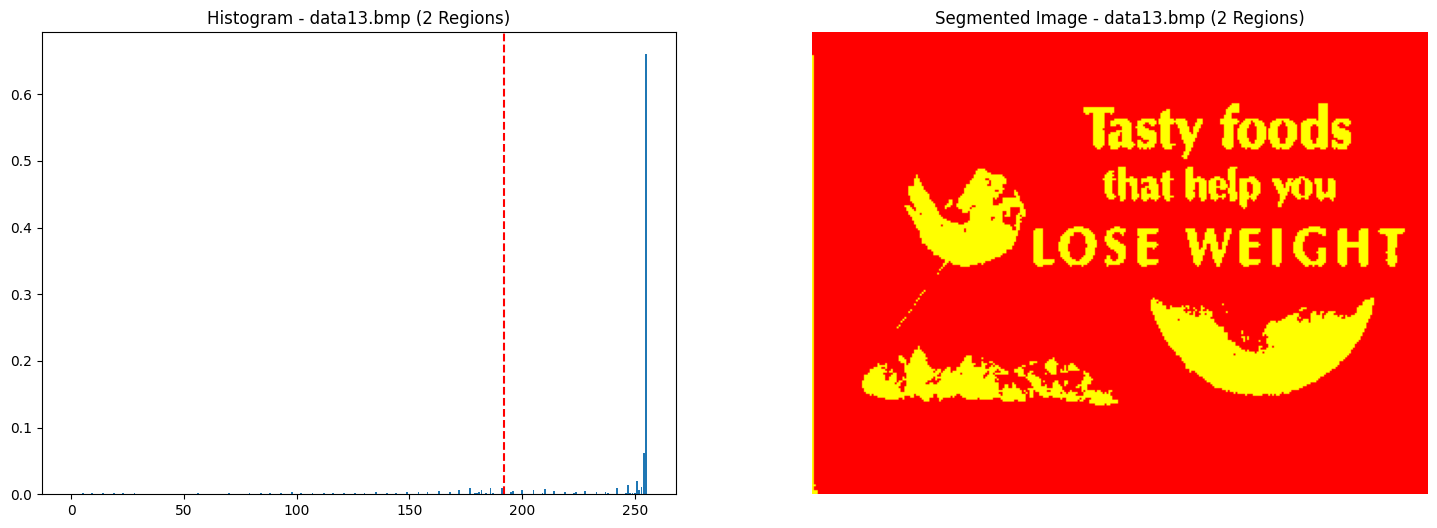



---------------------------------------------------------------------


Image: data13.bmp, Regions: 3
Thresholds: [119, 216]
Total Variance: 157.39084497197751
Variance of region 1: 1369.642270922771
Variance of region 2: 541.9420377553427
Variance of region 3: 24.57908209315522


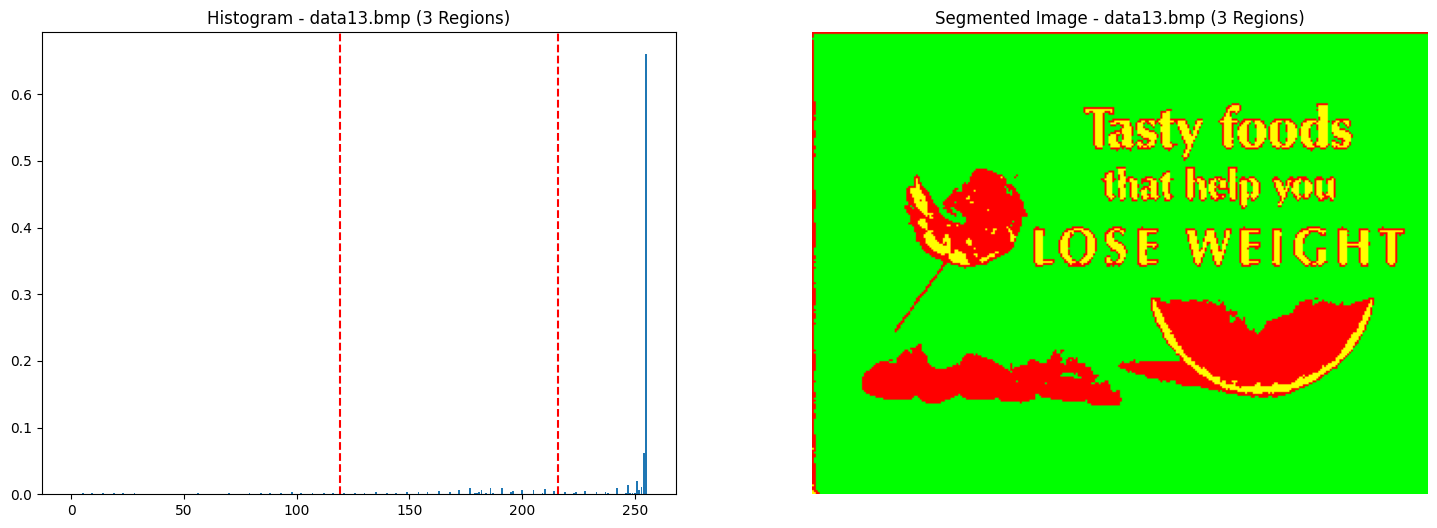



---------------------------------------------------------------------


Image: data13.bmp, Regions: 4
Thresholds: [76, 154, 221]
Total Variance: 82.61031549127037
Variance of region 1: 533.7761499167901
Variance of region 2: 544.6562993043916
Variance of region 3: 256.4135479608642
Variance of region 4: 18.04730356305332


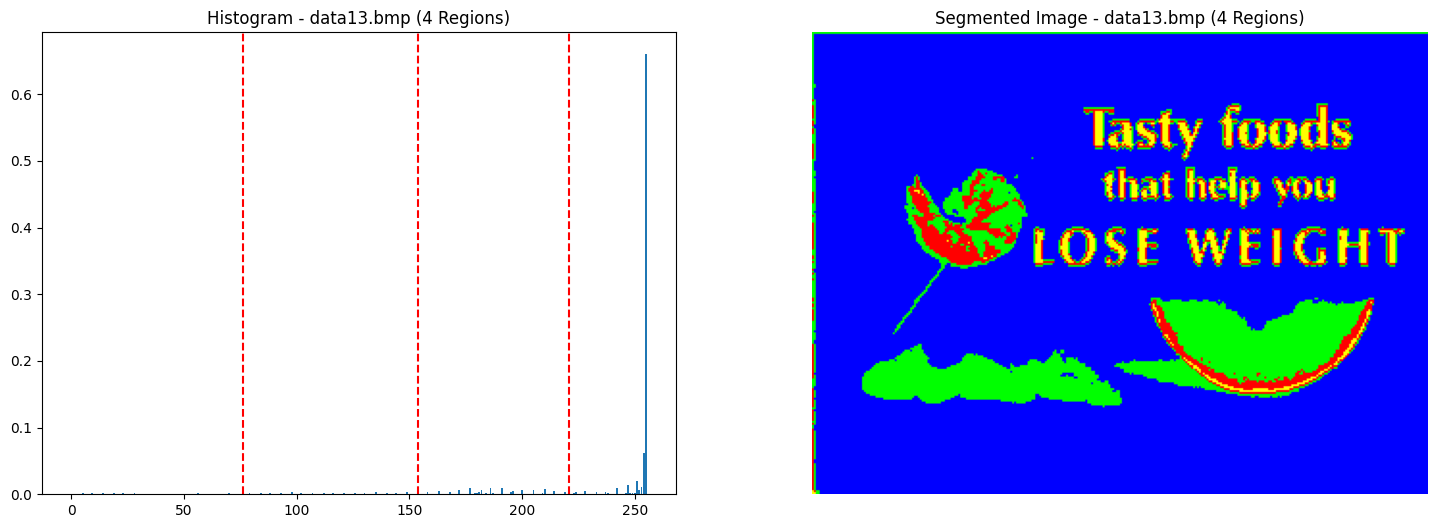



---------------------------------------------------------------------


Image: basket_balls.bmp, Regions: 2
Thresholds: [187]
Total Variance: 327.73814052981885
Variance of region 1: 742.2857629900017
Variance of region 2: 30.055614873143984


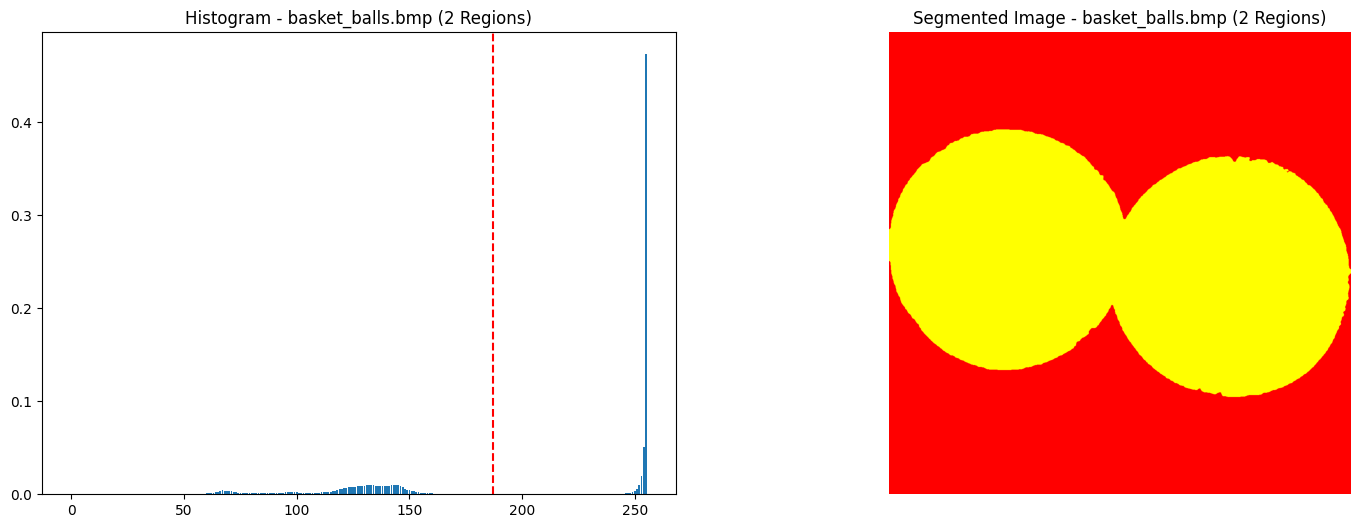



---------------------------------------------------------------------


Image: basket_balls.bmp, Regions: 3
Thresholds: [106, 194]
Total Variance: 91.39958050373265
Variance of region 1: 242.48684987526443
Variance of region 2: 169.89356076924224
Variance of region 3: 22.412760087565218


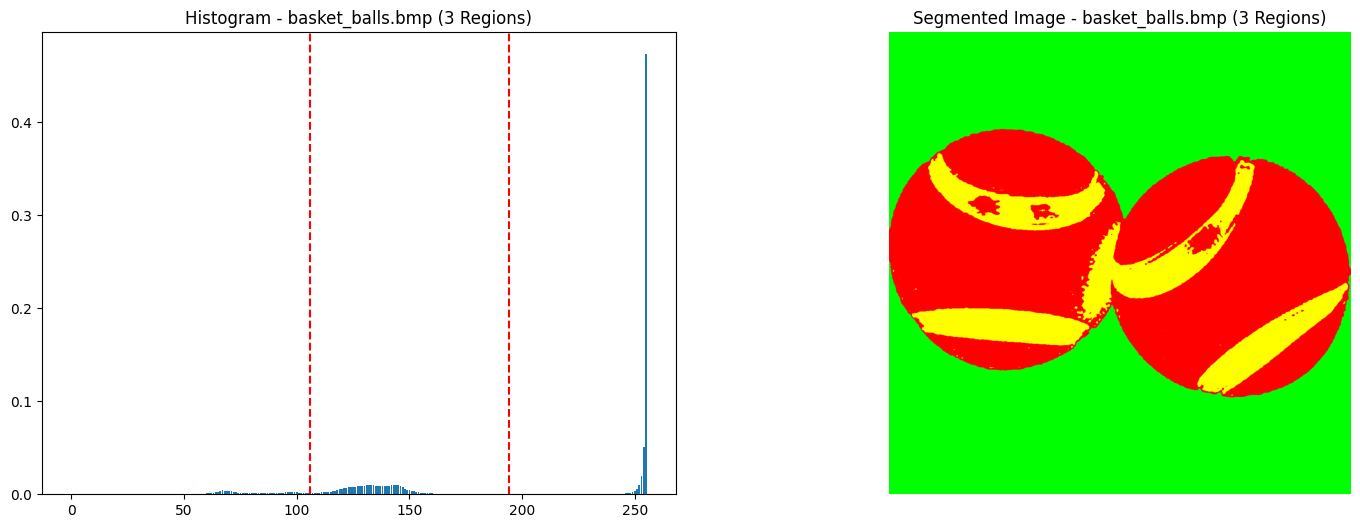



---------------------------------------------------------------------


Image: basket_balls.bmp, Regions: 4
Thresholds: [99, 133, 199]
Total Variance: 55.60880394421693
Variance of region 1: 192.41437130862047
Variance of region 2: 69.35895232344893
Variance of region 3: 100.39076712742194
Variance of region 4: 17.860184646893426


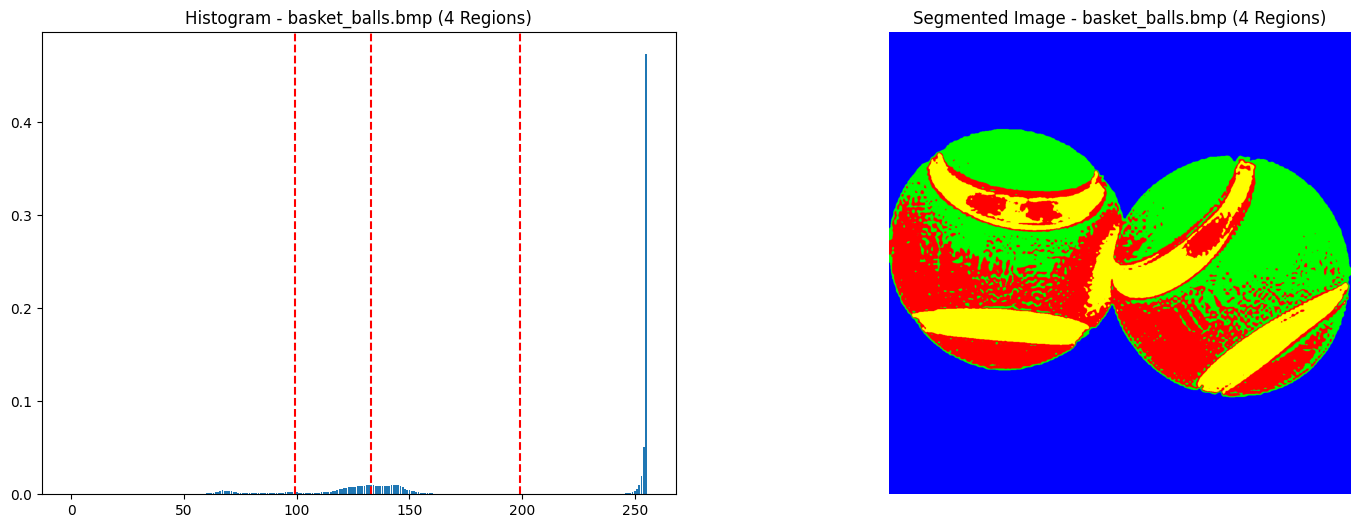



---------------------------------------------------------------------


Image: tiger1.bmp, Regions: 2
Thresholds: [108]
Total Variance: 1295.6351638032734
Variance of region 1: 1042.5348616782978
Variance of region 2: 1718.1472538683338


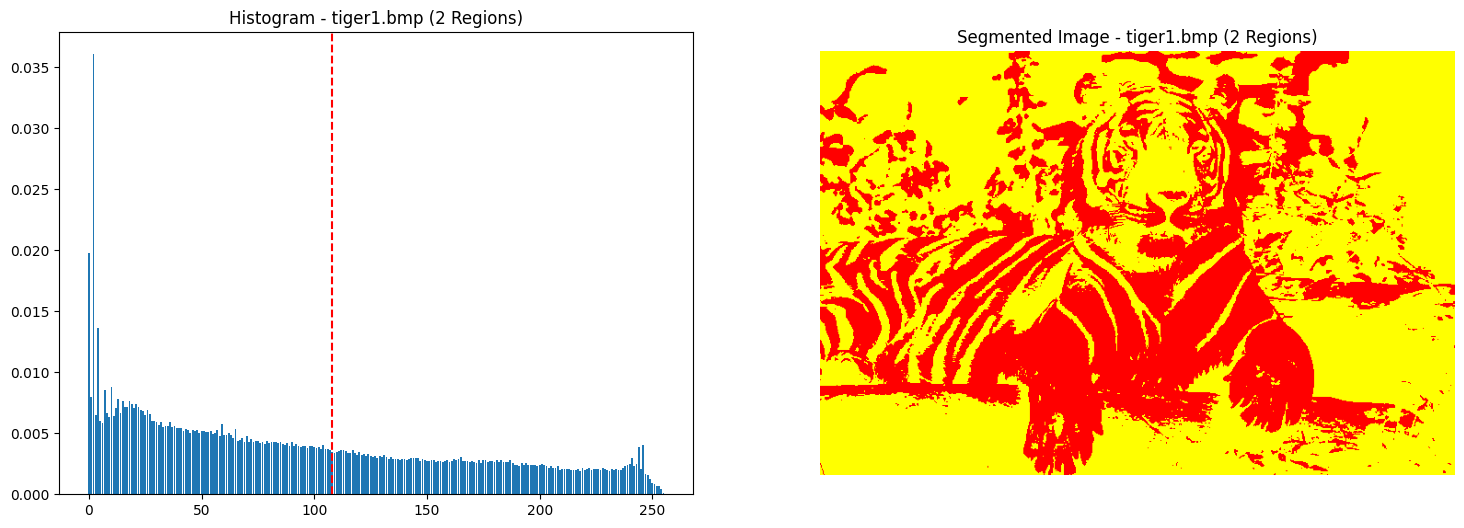



---------------------------------------------------------------------


Image: tiger1.bmp, Regions: 3
Thresholds: [66, 152]
Total Variance: 568.2176206291495
Variance of region 1: 404.72434634883246
Variance of region 2: 603.2316734744209
Variance of region 3: 833.9246770580347


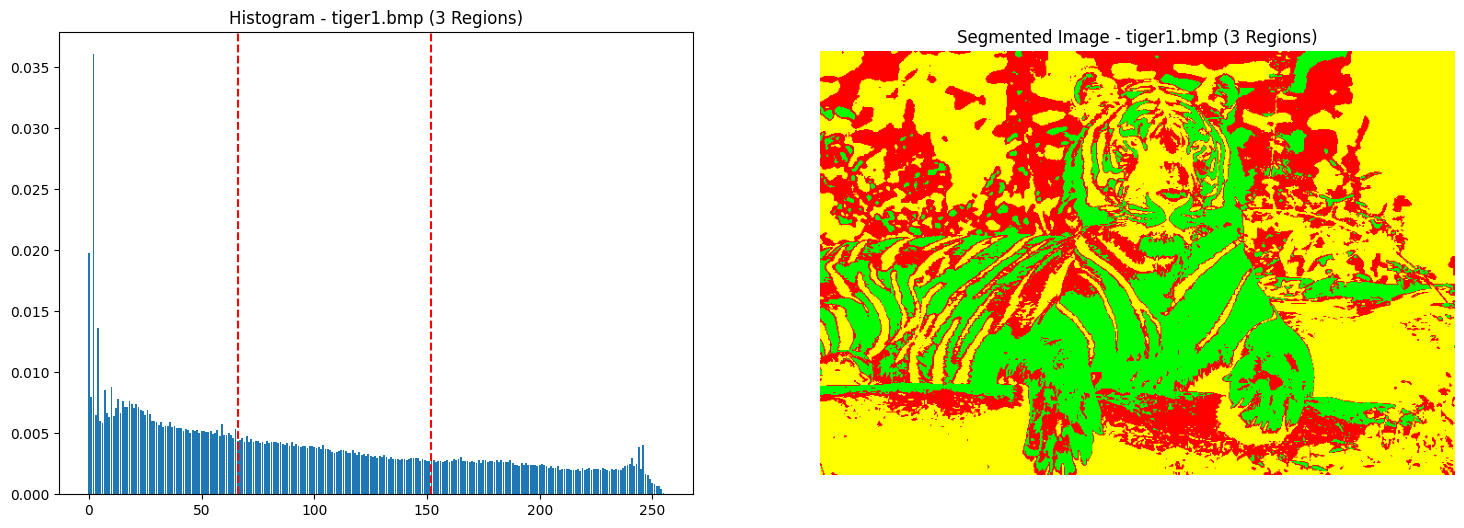



---------------------------------------------------------------------


Image: tiger1.bmp, Regions: 4
Thresholds: [48, 109, 177]
Total Variance: 321.1087978231893
Variance of region 1: 215.10989944956125
Variance of region 2: 309.1156668982463
Variance of region 3: 393.76755381154686
Variance of region 4: 480.225094664084


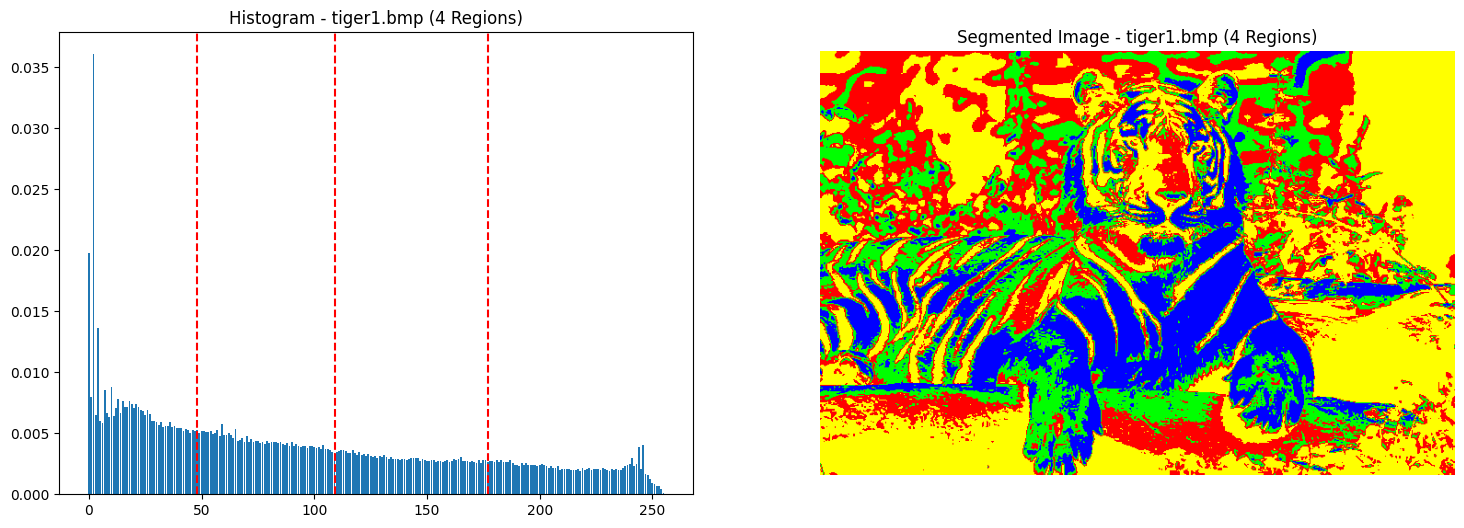



---------------------------------------------------------------------




In [118]:
# Define images and regions
test_images = ["data13.bmp", "basket_balls.bmp", "tiger1.bmp"]
regions = [2, 3, 4]

# Create Output Images folder
output_images_folder = "Output Images"
os.makedirs(output_images_folder, exist_ok=True)

# Iterate over each image
for image_path in test_images:
    # Open the given image
    image = Image.open(image_path)

    # Convert it to grayscaled image using the given formula
    grayscale_image = convert_to_grayscale(image)

    # Calculate its histogram
    hist = compute_histogram(grayscale_image)

    # For a given image, apply Otsu's method for 2-3-4 regions
    for N in regions:
        # Apply Otsu's method
        thresholds, total_var, group_variances = otsu(hist, N-1)

        # Print results
        print(f"Image: {image_path}, Regions: {N}")
        print("Thresholds:", thresholds)
        print("Total Variance:", total_var)
        for i, var in enumerate(group_variances):
            print(f"Variance of region {i+1}: {var}")

        # Segment the given image according to threshold values
        segmented_image = segment_image(grayscale_image, thresholds)

        # Create folder for each region
        folder_name = os.path.join(output_images_folder, f"{N} Region")
        os.makedirs(folder_name, exist_ok=True)

        # Save segmented image
        output_path = os.path.join(folder_name, image_path.replace('.bmp', '-out.bmp'))
        Image.fromarray(segmented_image).save(output_path)

        # Plot results
        plt.figure(figsize=(18,6))
        plt.subplot(1,2,1)
        plt.title(f'Histogram - {image_path} ({N} Regions)')
        plt.bar(np.arange(256), hist)
        for threshold in thresholds:
            plt.axvline(x=threshold, color='r', linestyle='--')

        plt.subplot(1,2,2)
        plt.title(f'Segmented Image - {image_path} ({N} Regions)')
        plt.imshow(segmented_image, cmap='gray')
        plt.axis('off')
        plt.show()

        print("\n\n---------------------------------------------------------------------\n\n")